# PyTorch를 활용한 다중 클래스 분류: CIFAR10 데이터셋으로 MLP와 CNN 모델 비교

이번에는 PyTorch를 사용하여 CIFAR10 데이터셋으로 다중 클래스 분류(Multiclass Classification) 문제를 해결하는 과정을 단계별로 살펴보도록 하겠습니다.

다층 퍼셉트론(MLP) 모델과 컨볼루션 신경망(CNN) 모델을 구현하고, 두 모델의 성능을 비교하기 위해서, 데이터 로드부터 모델 학습, 평가 및 시각화까지의 전 과정을 포함하며, 모델 성능을 개선하기 위한 과제도 함께 제공합니다.

## 학습 목표

- CIFAR10 데이터셋을 이용한 다중 클래스 분류 문제 이해
- PyTorch를 사용한 MLP와 CNN 모델 구현 및 학습 방법 습득
- 모델 평가 및 결과 해석 능력 향상
- 딥러닝 모델 개선을 위한 다양한 기법 이해
- MLP와 CNN 모델의 성능 비교 및 이해


## 1. 필요한 라이브러리 import 및 설정

먼저, 모델 구축과 데이터 처리를 위해 필요한 라이브러리를 불러오고, 장치 설정 및 시드 고정을 진행합니다.

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

# GPU 사용 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# 재현성을 위한 시드 설정
torch.manual_seed(42)

Using device: cuda


## 2. 하이퍼파라미터 및 설정

모델 학습에 필요한 하이퍼파라미터를 설정하고, 결과를 저장할 디렉토리를 생성합니다.

In [ ]:
# 하이퍼파라미터 설정
BATCH_SIZE = 32
LR = 1e-3
EPOCH = 5
criterion = nn.CrossEntropyLoss()
model_types = ["MLP", "CNN"]  # 비교할 모델 유형 리스트
dataset = "CIFAR10"

# 결과 저장을 위한 디렉토리 생성
if not os.path.exists('./results'):
    os.makedirs('./results')

save_model_paths = {model_type: f"./results/{model_type}_{dataset}.pt" for model_type in model_types}

# 설명:
# - BATCH_SIZE: 한 번에 처리할 데이터 수
# - LR: 학습률 (Learning Rate)
# - EPOCH: 전체 데이터셋을 반복 학습할 횟수
# - criterion: 손실 함수 (여기서는 Cross Entropy Loss 사용)
# - model_types: 비교할 모델의 리스트 (MLP와 CNN)
# - save_model_paths: 각 모델의 학습된 상태를 저장할 경로


## 3. 데이터 준비

CIFAR10 데이터셋을 다운로드하고, DataLoader를 사용하여 배치 처리를 준비합니다.

In [ ]:
# 데이터 변환 정의
transform = transforms.ToTensor()

# CIFAR10 데이터셋 다운로드
train_DS = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_DS = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoader 생성
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataset size: {len(train_DS)}")
print(f"Test dataset size: {len(test_DS)}")

Files already downloaded and verified
Files already downloaded and verified
Train dataset size: 50000
Test dataset size: 10000


- transforms.ToTensor(): 이미지를 PyTorch 텐서로 변환.
- datasets.CIFAR10: CIFAR10 데이터셋 로드.
- DataLoader: 배치 처리를 위한 데이터 로더 생성.
- shuffle=True: 훈련 데이터셋을 섞어 학습의 일반화 성능 향상.

이 출력은 훈련 데이터셋이 50,000개의 이미지를, 테스트 데이터셋이 10,000개의 이미지를 포함하고 있음을 보여줍니다.

## 4. 데이터 탐색

CIFAR10 데이터셋의 클래스들을 출력하고, 첫 번째 배치의 이미지와 라벨을 시각화합니다.


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Class to index mapping: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Batch shape: torch.Size([32, 3, 32, 32])
Labels shape: torch.Size([32])


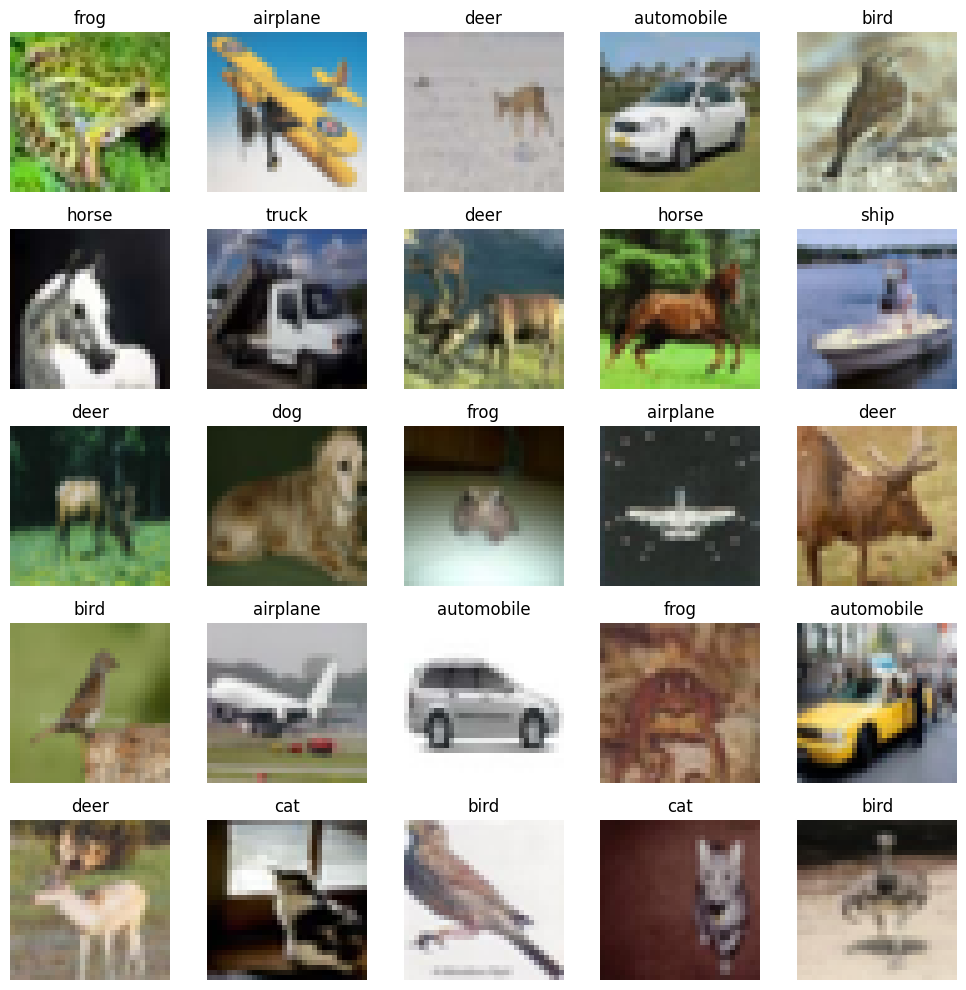

In [ ]:
# 클래스 정보 출력
print("Classes:", train_DS.classes)
print("Class to index mapping:", train_DS.class_to_idx)

# 첫 번째 배치의 이미지와 라벨 확인
x_batch, y_batch = next(iter(train_DL))
print("Batch shape:", x_batch.shape)
print("Labels shape:", y_batch.shape)

# 첫 번째 배치의 일부 이미지 시각화
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    img = x_batch[i].permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
    plt.imshow(img)
    plt.title(train_DS.classes[y_batch[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

- 클래스 정보: CIFAR10은 10개의 클래스(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)로 구성됨.
- 배치 형태: 배치 크기 32, 이미지 채널 3(RGB), 크기 32x32.
- 이미지 시각화: 첫 번째 배치의 25개 이미지를 그리드 형태로 시각화하여 데이터의 분포와 품질을 확인.


## STEP 5: 모델 정의

여기서는 두 가지 모델(MLP와 CNN)을 정의합니다. 각 모델의 구조는 다음과 같습니다.

1. MLP: 간단한 다층 퍼셉트론 모델.
2. CNN: 기본적인 컨볼루션 신경망 모델.

In [ ]:
# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(3*32*32, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x

# 기본 CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.Maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.Maxpool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.Maxpool3 = nn.MaxPool2d(2)
        self.fc = nn.Linear(32*4*4, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.Maxpool1(x)
        x = self.conv2(x)
        x = self.Maxpool2(x)
        x = self.conv3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

- MLP (다층 퍼셉트론):

    - 구조: 입력층(33232) → 은닉층(100) → 출력층(10).
    - 활성화 함수: ReLU.

- CNN (기본 컨볼루션 신경망):
    - 구조: 3개의 컨볼루션 블록 → 완전 연결층.
    - 컨볼루션 블록: Conv2d → BatchNorm → ReLU → MaxPool.
    - 출력: 32채널의 4x4 특징 맵 → Flatten → Linear → 출력층.

In [ ]:
models = {
    "MLP": MLP().to(DEVICE),
    "CNN": CNN().to(DEVICE),
}

- MLP와 CNN 모델을 각각 인스턴스화하고 GPU로 이동.

In [ ]:
# 모델 출력 형태 확인
x_sample, _ = next(iter(train_DL))
for model_type, model in models.items():
    output = model(x_sample.to(DEVICE))
    print(f"{model_type} 모델의 출력 형태: {output.shape}")

MLP 모델의 출력 형태: torch.Size([32, 10])
CNN 모델의 출력 형태: torch.Size([32, 10])


- 각 모델의 구조를 출력하여 확인.

## 6. 모델 학습

각 모델을 학습시키고, 학습 과정에서의 손실 변화를 그래프로 시각화합니다.



In [ ]:
def Train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    loss_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f"Epoch: {epoch+1}, Train Loss: {epoch_loss:.3f}")
        print("-" * 20)

    return loss_history

- Train 함수

    - 모델 학습 모드 설정: model.train().
    - 순전파 및 역전파
        - optimizer.zero_grad(): 이전 기울기 초기화.
        - outputs = model(inputs): 모델을 통해 예측값 계산.
        - loss = criterion(outputs, labels): 손실 계산.
        - loss.backward(): 기울기 계산.
        - optimizer.step(): 파라미터 업데이트.

    - 손실 기록 및 출력: 각 에포크의 평균 손실 값을 기록하고 출력.

=== MLP 모델 학습 시작 ===
Epoch: 1, Train Loss: 1.876
--------------------
Epoch: 2, Train Loss: 1.732
--------------------
Epoch: 3, Train Loss: 1.672
--------------------
Epoch: 4, Train Loss: 1.632
--------------------
Epoch: 5, Train Loss: 1.608
--------------------
MLP 모델 학습 완료 및 저장됨.



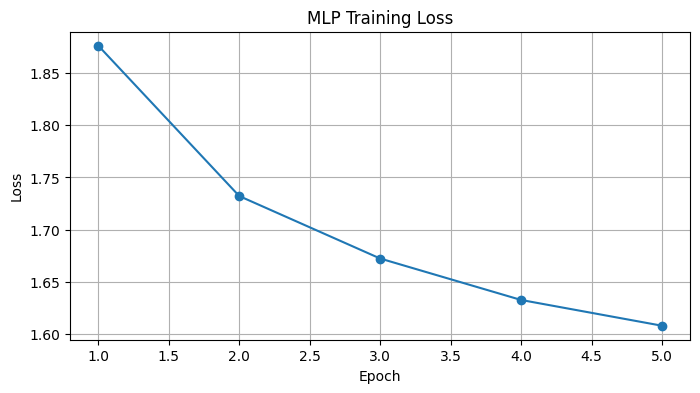

=== CNN 모델 학습 시작 ===
Epoch: 1, Train Loss: 1.334
--------------------
Epoch: 2, Train Loss: 1.041
--------------------
Epoch: 3, Train Loss: 0.944
--------------------
Epoch: 4, Train Loss: 0.883
--------------------
Epoch: 5, Train Loss: 0.840
--------------------
CNN 모델 학습 완료 및 저장됨.



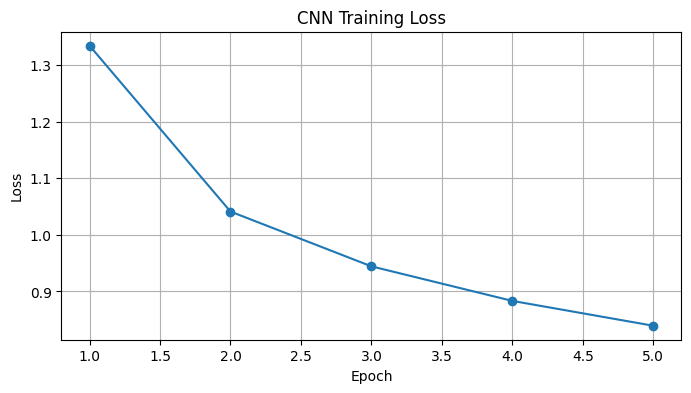

In [ ]:
# 모델 학습 및 저장
loss_histories = {}
for model_type in model_types:
    print(f"=== {model_type} 모델 학습 시작 ===")
    model = models[model_type]
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_history = Train(model, train_DL, criterion, optimizer, EPOCH)
    loss_histories[model_type] = loss_history
    torch.save(model.state_dict(), save_model_paths[model_type])
    print(f"{model_type} 모델 학습 완료 및 저장됨.\n")

    # 학습 손실 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, EPOCH+1), loss_history, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"{model_type} Training Loss")
    plt.grid(True)
    plt.show()

- 모델 학습 및 저장
    - model_types 리스트에 따라 MLP와 CNN 모델을 각각 학습.
    - 학습된 모델의 상태를 파일로 저장.
    - 각 모델의 학습 손실 변화를 그래프로 시각화.

### 학습 과정 해석

- Epoch 1에서 손실이 높게 시작하지만, 각 에폭마다 손실이 감소하는 것을 볼 수 있습니다.
- 마지막 에폭에서 손실이 0.522로 감소했는데, 이는 모델이 학습 데이터에 대해 잘 적응하고 있음을 나타냅니다.
- 그러나 이것이 반드시 테스트 데이터에 대한 좋은 성능을 보장하지는 않으므로, 과적합 여부를 확인해야 합니다.

## 7. 모델 로드 및 평가

학습된 모델을 로드하고, 테스트 데이터셋을 사용하여 모델의 성능을 평가합니다.

In [ ]:
def Test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f"Test Accuracy: {correct}/{total} ({accuracy:.2f}%)")
    return accuracy

- Test 함수

    - 모델 평가 모드 설정: model.eval().
    - 기울기 계산 비활성화: torch.no_grad()로 메모리 절약 및 계산 속도 향상.
    - 예측 및 정확도 계산: 모델의 예측값과 실제 레이블을 비교하여 정확도 산출.

In [ ]:
# 모델 로드 및 평가
test_accuracies = {}
for model_type in model_types:
    print(f"=== {model_type} 모델 로드 및 평가 ===")
    model = models[model_type]
    model.load_state_dict(torch.load(save_model_paths[model_type], map_location=DEVICE))
    accuracy = Test(model, test_DL)
    test_accuracies[model_type] = accuracy
    print("-" * 20)

=== MLP 모델 로드 및 평가 ===


<ipython-input-11-55f020171b20>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model_paths[model_type], map_location=DEVICE))


Test Accuracy: 4285/10000 (42.85%)
--------------------
=== CNN 모델 로드 및 평가 ===
Test Accuracy: 6632/10000 (66.32%)
--------------------


- 모델 로드 및 평가
    - model_types 리스트에 따라 MLP와 CNN 모델을 각각 로드.
    - 저장된 모델의 상태를 로드하여 모델에 적용.
    - 테스트 데이터셋을 사용하여 모델의 성능을 평가하고 정확도 기록.

## 8. 예측 결과 시각화
각 모델의 예측 결과를 시각화하여 실제 레이블과의 일치를 확인합니다.

In [ ]:
def Test_plot(model, test_loader, num_samples=25):
    model.eval()
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes_flat = axes.ravel()  # Flatten the array of subplot objects.
    samples_plotted = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            for i in range(inputs.size(0)):
                if samples_plotted >= num_samples:
                    break
                img = inputs[i].cpu().permute(1, 2, 0)
                ax = axes_flat[samples_plotted]
                ax.imshow(img)
                pred_class = test_loader.dataset.classes[predicted[i]]
                true_class = test_loader.dataset.classes[labels[i]]
                ax.set_title(f"Pred: {pred_class}\nTrue: {true_class}",
                             color="green" if pred_class == true_class else "red")
                ax.axis('off')
                samples_plotted += 1

            if samples_plotted >= num_samples:
                break

    plt.tight_layout()
    plt.show()

- Test_plot 함수

    - 모델 평가 모드 설정: model.eval().
    - 예측 결과 시각화: 지정된 수의 샘플에 대해 예측 결과와 실제 레이블을 시각적으로 표시.
    - 정확도 색상 표시: 예측이 정확하면 제목을 초록색, 아니면 빨간색으로 표시하여 한눈에 확인 가능.

- 이미지 변환: (C, H, W)에서 (H, W, C)로 변환하여 시각화.

- 샘플 제한: 지정된 num_samples 만큼만 시각화하여 과도한 그래프 생성을 방지.

=== MLP 모델 예측 결과 시각화 ===


<ipython-input-13-ebb9d74ba7fc>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model_paths[model_type], map_location=DEVICE))


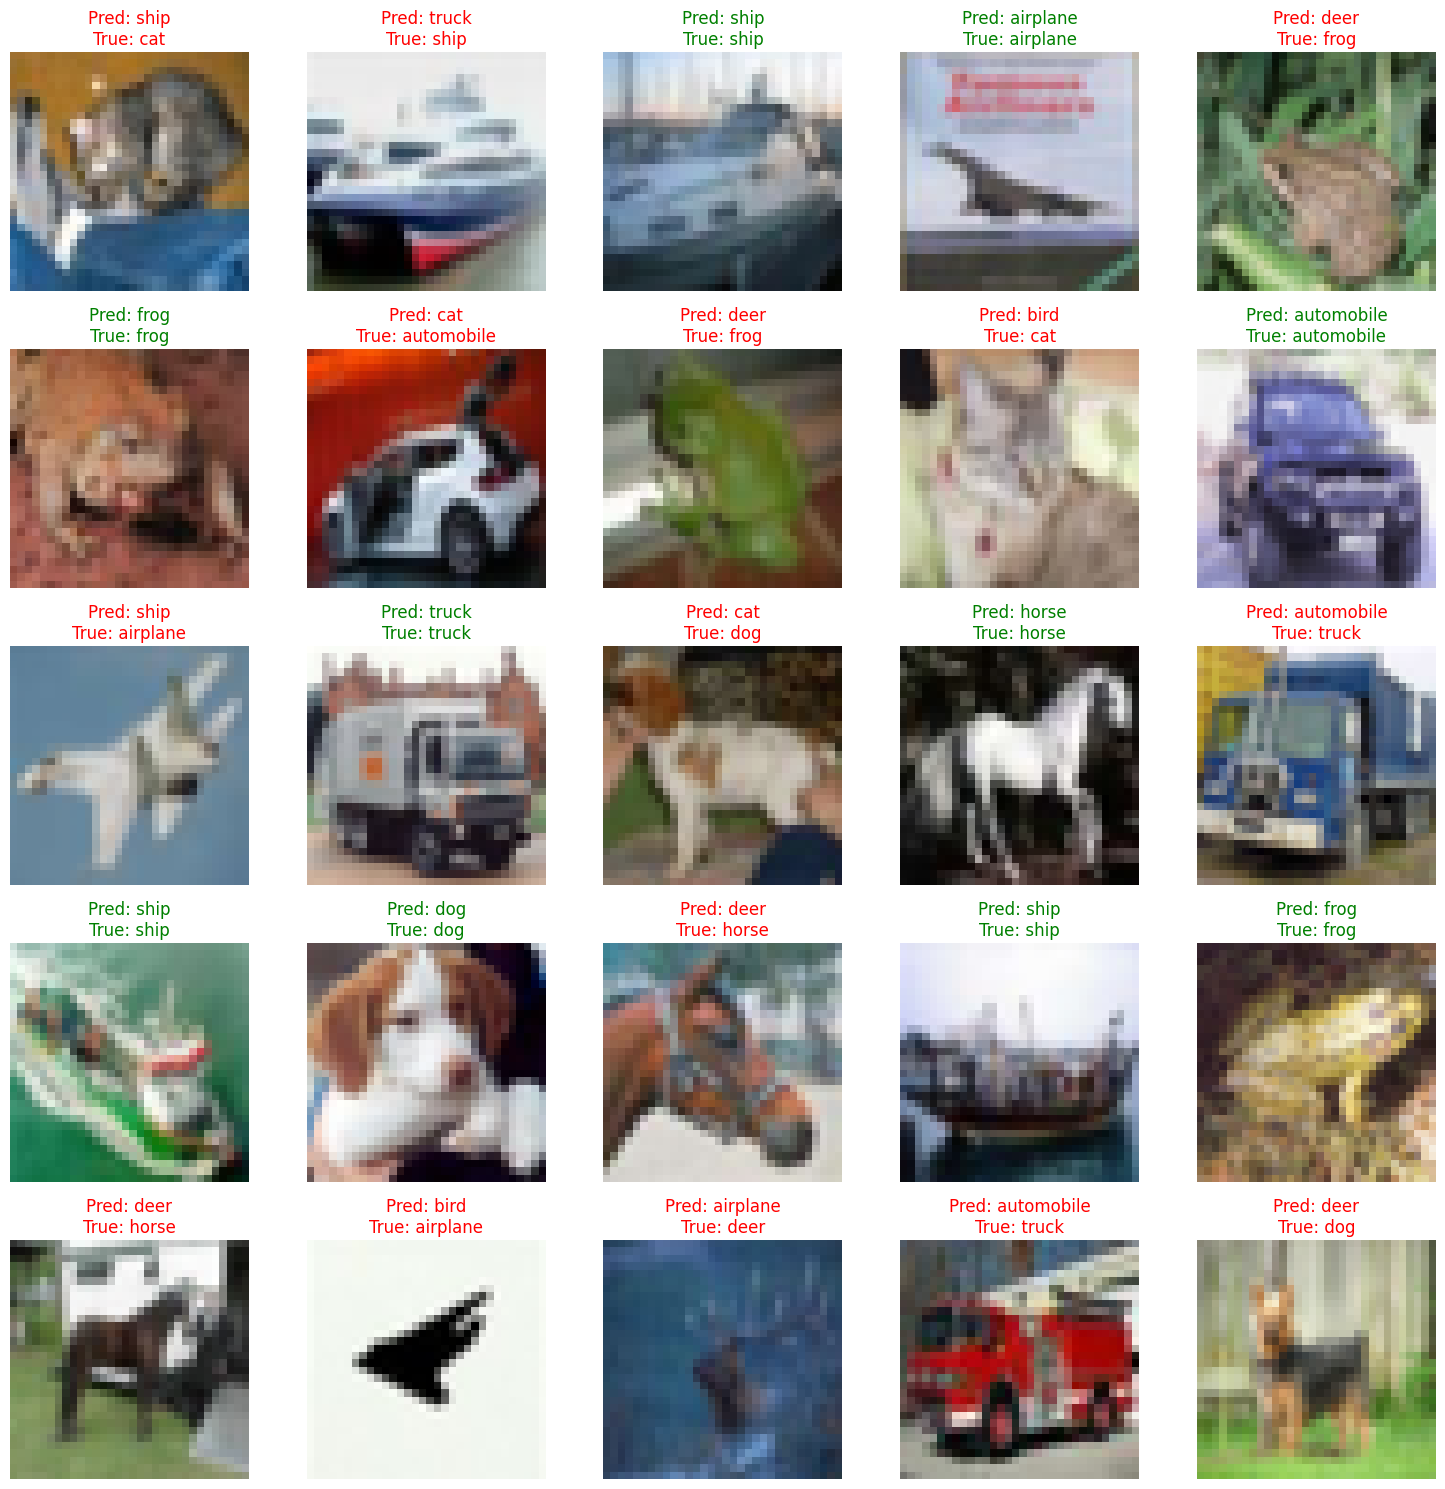

--------------------
=== CNN 모델 예측 결과 시각화 ===


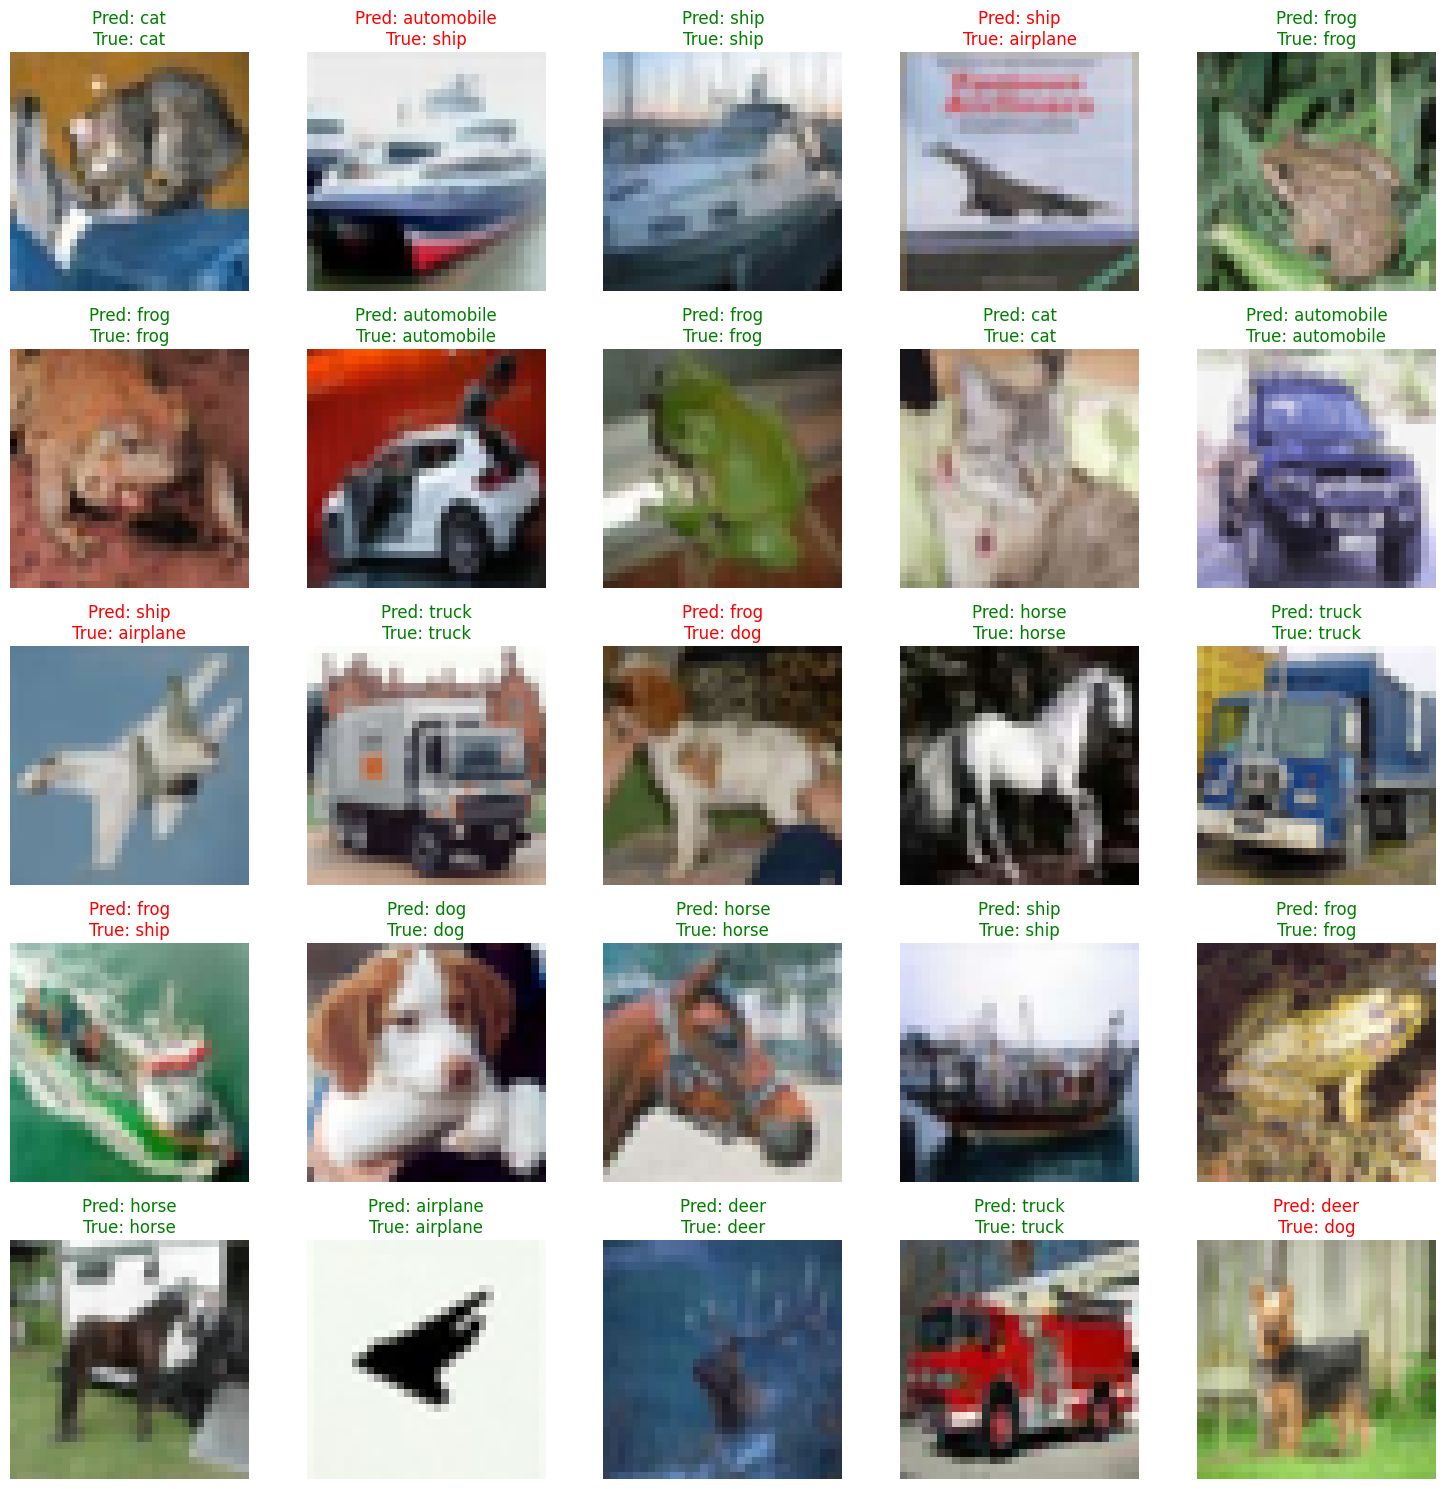

--------------------


In [ ]:
# 예측 결과 시각화
for model_type in model_types:
    print(f"=== {model_type} 모델 예측 결과 시각화 ===")
    model = models[model_type]
    model.load_state_dict(torch.load(save_model_paths[model_type], map_location=DEVICE))
    Test_plot(model, test_DL, num_samples=25)
    print("-" * 20)

### 9. 모델 파라미터 수 계산
모델의 학습 가능한 파라미터 수를 계산하여 모델의 복잡성을 파악합니다.


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 모델 파라미터 수 계산 및 출력
for model_type in model_types:
    model = models[model_type]
    total_params = count_parameters(model)
    print(f"{model_type} 모델의 총 학습 가능한 파라미터 수: {total_params}")

MLP 모델의 총 학습 가능한 파라미터 수: 308310
CNN 모델의 총 학습 가능한 파라미터 수: 11274


- 파라미터 수 계산: 모델의 모든 학습 가능한 파라미터 수를 합산하여 출력.
- 모델 복잡성 파악: 파라미터 수가 많을수록 모델의 복잡성이 높아지며, 학습에 필요한 데이터와 계산량도 증가.


### 10. 모델 비교 및 성능 요약
MLP와 CNN 모델의 학습 손실, 테스트 정확도 등을 비교하여 성능을 요약합니다.

In [ ]:
import pandas as pd

# 손실 및 정확도 비교를 위한 데이터프레임 생성
comparison_data = {
    "Model": [],
    "Final Train Loss": [],
    "Final Test Accuracy (%)": [],
    "Total Parameters": []
}

for model_type in model_types:
    comparison_data["Model"].append(model_type)
    comparison_data["Final Train Loss"].append(loss_histories[model_type][-1])
    comparison_data["Final Test Accuracy (%)"].append(test_accuracies[model_type])
    comparison_data["Total Parameters"].append(count_parameters(models[model_type]))

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

  Model  Final Train Loss  Final Test Accuracy (%)  Total Parameters
0   MLP          1.607756                    42.85            308310
1   CNN          0.839506                    66.32             11274


- 데이터프레임 생성
    - 각 모델의 최종 학습 손실, 최종 테스트 정확도, 총 학습 가능한 파라미터 수를 비교하기 위한 표를 생성.

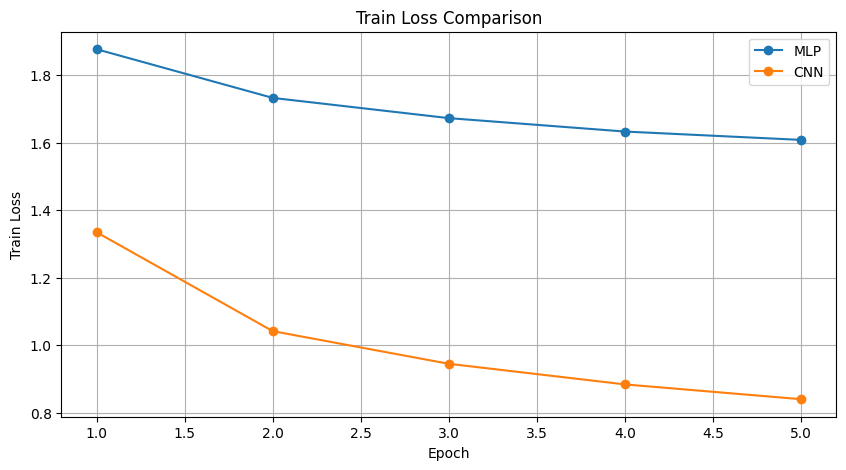

In [ ]:
# 손실 비교 그래프
plt.figure(figsize=(10, 5))
for model_type in model_types:
    plt.plot(range(1, EPOCH+1), loss_histories[model_type], marker='o', label=model_type)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

- 손실 비교 그래프

    - 각 에포크별 학습 손실을 그래프로 시각화하여 모델 간 학습 진행 상황을 비교.


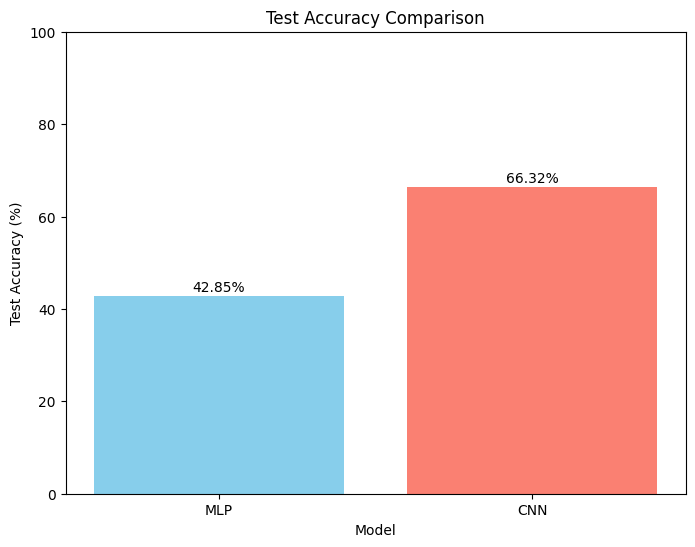

In [ ]:
# 정확도 비교 그래프
plt.figure(figsize=(8, 6))
plt.bar(comparison_df["Model"], comparison_df["Final Test Accuracy (%)"], color=['skyblue', 'salmon'])
plt.xlabel('Model')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.ylim(0, 100)
for index, value in enumerate(comparison_df["Final Test Accuracy (%)"]):
    plt.text(index, value + 1, f"{value:.2f}%", ha='center')
plt.show()

- 정확도 비교 그래프

    - 각 모델의 최종 테스트 정확도를 바 그래프로 시각화하여 모델 간 성능을 비교.

## 9. 과제: 모델 성능 개선하기

현재 설정된 하이퍼파라미터와 모델 구조로 인해 MLP와 CNN 모델의 성능이 일부러 좋지 않게 설정되었습니다. 다음 과제를 통해 모델의 성능을 개선해 보세요.

### 과제 내용

1. 학습률 (Learning Rate) 조정

    - 현재 학습률 LR=1e-3을 변경하여 모델의 학습 속도와 성능을 관찰해 보세요.

    - 시도해 볼 것
        - 예시, 더 높은 학습률 (LR=1e-2) 또는 더 낮은 학습률 (LR=1e-4) 설정.

    - 코드 예시
    ```
    # 학습률 변경 예시
    LR = 1e-2  # 또는 1e-4
    optimizer = optim.Adam(model.parameters(), lr=LR)
    ```

2. 에포크 수 증가

    - 현재 에포크 수 EPOCH=5를 늘려 모델이 충분히 학습할 수 있도록 해보세요.
    - 시도해 볼 것
        - EPOCH=20 또는 EPOCH=50으로 설정하고 학습 과정을 관찰.
    - 코드 예시
    ```
    # 에포크 수 증가 예시
    EPOCH = 20
    loss_history = Train(model, train_DL, criterion, optimizer, EPOCH)
    ```

3. 모델 구조 변경

    - 더 깊은 신경망이나 추가적인 컨볼루션 레이어를 추가하여 모델의 표현력을 높여보세요.
    ```
    class ImprovedCNN_deep(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv_block1 = nn.Sequential(
                nn.Conv2d(3, 32, 3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Conv2d(32, 32, 3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Conv2d(32, 32, 3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Dropout(0.2)
            )
            self.Maxpool1 = nn.MaxPool2d(2)

            self.conv_block2 = nn.Sequential(
                nn.Conv2d(32, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(64, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(64, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Dropout(0.2)
            )
            self.Maxpool2 = nn.MaxPool2d(2)

            self.conv_block3 = nn.Sequential(
                nn.Conv2d(64, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Conv2d(128, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Conv2d(128, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Dropout(0.2)
            )
            self.Maxpool3 = nn.MaxPool2d(2)

            self.classifier = nn.Sequential(
                nn.Linear(128*4*4, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, 10)
            )

        def forward(self, x):
            x = self.conv_block1(x)
            x = self.Maxpool1(x)
            x = self.conv_block2(x)
            x = self.Maxpool2(x)
            x = self.conv_block3(x)
            x = self.Maxpool3(x)
            x = torch.flatten(x, start_dim=1)
            x = self.classifier(x)
            return x
            ```

4. 손실 함수 및 옵티마이저 변경

    - nn.CrossEntropyLoss 대신 nn.NLLLoss를 사용해 보세요. 이 경우 출력에 log_softmax를 적용해야 합니다.
    - 옵티마이저를 SGD 또는 RMSprop으로 변경하여 학습 속도와 성능을 비교해 보세요.

    ```
    # 손실 함수 변경 예시
    criterion = nn.NLLLoss()

    # 모델의 출력에 log_softmax 적용
    class ImprovedCNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Sequential(
                nn.Conv2d(3, 8, 3, padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU()
            )
            self.Maxpool1 = nn.MaxPool2d(2)
            # ... (생략)
            self.fc = nn.Sequential(
                nn.Linear(32*4*4, 10),
                nn.LogSoftmax(dim=1)  # log_softmax 추가
            )

        def forward(self, x):
            # 기존 순전파
            x = self.conv1(x)
            x = self.Maxpool1(x)
            # ... (생략)
            x = self.fc(x)
            return x

    # 옵티마이저 변경 예시
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    ```

5. 데이터 정규화 (Normalization):

    - 특징 데이터의 스케일을 조정하여 모델 학습을 용이하게 만드세요.
    ```
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 평균과 표준편차 설정
    ])
    train_DS = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_DS = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))
    train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
    test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=False)
    ```

6. 정규화 기법 적용

    - 과적합을 방지하기 위해 드롭아웃(Dropout)이나 배치 정규화(Batch Normalization)를 추가적으로 적용해 보세요.

    - 예시
    ```
    class ImprovedCNN_deep(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv_block1 = nn.Sequential(
                nn.Conv2d(3, 32, 3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Conv2d(32, 32, 3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Conv2d(32, 32, 3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Dropout(0.2)
            )
            self.Maxpool1 = nn.MaxPool2d(2)

            self.conv_block2 = nn.Sequential(
                nn.Conv2d(32, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(64, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(64, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Dropout(0.2)
            )
            self.Maxpool2 = nn.MaxPool2d(2)

            self.conv_block3 = nn.Sequential(
                nn.Conv2d(64, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Conv2d(128, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Conv2d(128, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Dropout(0.2)
            )
            self.Maxpool3 = nn.MaxPool2d(2)

            self.classifier = nn.Sequential(
                nn.Linear(128*4*4, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, 10)
            )

        def forward(self, x):
            x = self.conv_block1(x)
            x = self.Maxpool1(x)
            x = self.conv_block2(x)
            x = self.Maxpool2(x)
            x = self.conv_block3(x)
            x = self.Maxpool3(x)
            x = torch.flatten(x, start_dim=1)
            x = self.classifier(x)
            return x
            ```

7. 데이터 증강 기법 적용

    - 이미지 회전, 이동 등 데이터 증강을 통해 데이터 다양성을 높이고 모델의 일반화 성능을 향상시켜 보세요.
    ```
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # CIFAR10 데이터셋 재정의
    train_DS = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_DS = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
    test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=False)
    ```

    - 다만, 데이터 증강 과정에서 시간이 많이 소요 될 수도 있으니 참고해주세요.

In [28]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

# GPU 사용 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# 재현성을 위한 시드 설정
torch.manual_seed(42)

Using device: cuda


In [29]:
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 평균과 표준편차 설정
])
train_DS = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_DS = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
# 기본 CNN 모델 정의
class CIFAR10Classification(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.Maxpool3 = nn.MaxPool2d(2)

        self.classifier = nn.Sequential(
            nn.Linear(128*4*4, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

In [31]:
def Train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    loss_history = []

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                         factor=0.1, patience=2)
    pre_lr = optimizer.param_groups[0]['lr']
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f"Epoch: {epoch+1}, Train Loss: {epoch_loss:.3f}")

        scheduler.step(epoch_loss)
        if optimizer.param_groups[0]['lr'] != pre_lr :
            print(f"Learning Rate {pre_lr} -> {optimizer.param_groups[0]['lr']}")
        pre_lr = optimizer.param_groups[0]['lr']

        print("-" * 20)



    return loss_history

In [38]:
model = CIFAR10Classification().to(DEVICE)

import torchsummary
torchsummary.summary(model, (3, 32, 32))

# 하이퍼파라미터 설정

LR = 1e-3
EPOCH = 50
criterion = nn.CrossEntropyLoss()

# 설명:
# - BATCH_SIZE: 한 번에 처리할 데이터 수
# - LR: 학습률 (Learning Rate)
# - EPOCH: 전체 데이터셋을 반복 학습할 횟수
# - criterion: 손실 함수 (여기서는 Cross Entropy Loss 사용)
# - model_types: 비교할 모델의 리스트 (MLP와 CNN)
# - save_model_paths: 각 모델의 학습된 상태를 저장할 경로


# 모델 학습 및 저장


print(f"=== 모델 학습 시작 ===")

optimizer = optim.AdamW(model.parameters(), lr=LR)
loss_history = Train(model, train_DL, criterion, optimizer, EPOCH)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,248
       BatchNorm2d-8           [-1, 32, 32, 32]              64
              ReLU-9           [-1, 32, 32, 32]               0
          Dropout-10           [-1, 32, 32, 32]               0
        MaxPool2d-11           [-1, 32, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          18,496
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

KeyboardInterrupt: 

In [ ]:
# 학습 손실 시각화
plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCH+1), loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"Training Loss")
plt.grid(True)
plt.show()

In [ ]:
def Test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f"Test Accuracy: {correct}/{total} ({accuracy:.2f}%)")
    return accuracy

In [35]:
# 모델 로드 및 평가
accuracy = Test(model, test_DL)

Test Accuracy: 8394/10000 (83.94%)


In [36]:
def Test_plot(model, test_loader, num_samples=25):
    model.eval()
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes_flat = axes.ravel()  # Flatten the array of subplot objects.
    samples_plotted = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            for i in range(inputs.size(0)):
                if samples_plotted >= num_samples:
                    break
                img = inputs[i].cpu().permute(1, 2, 0)
                ax = axes_flat[samples_plotted]
                ax.imshow(img)
                pred_class = test_loader.dataset.classes[predicted[i]]
                true_class = test_loader.dataset.classes[labels[i]]
                ax.set_title(f"Pred: {pred_class}\nTrue: {true_class}",
                             color="green" if pred_class == true_class else "red")
                ax.axis('off')
                samples_plotted += 1

            if samples_plotted >= num_samples:
                break

    plt.tight_layout()
    plt.show()

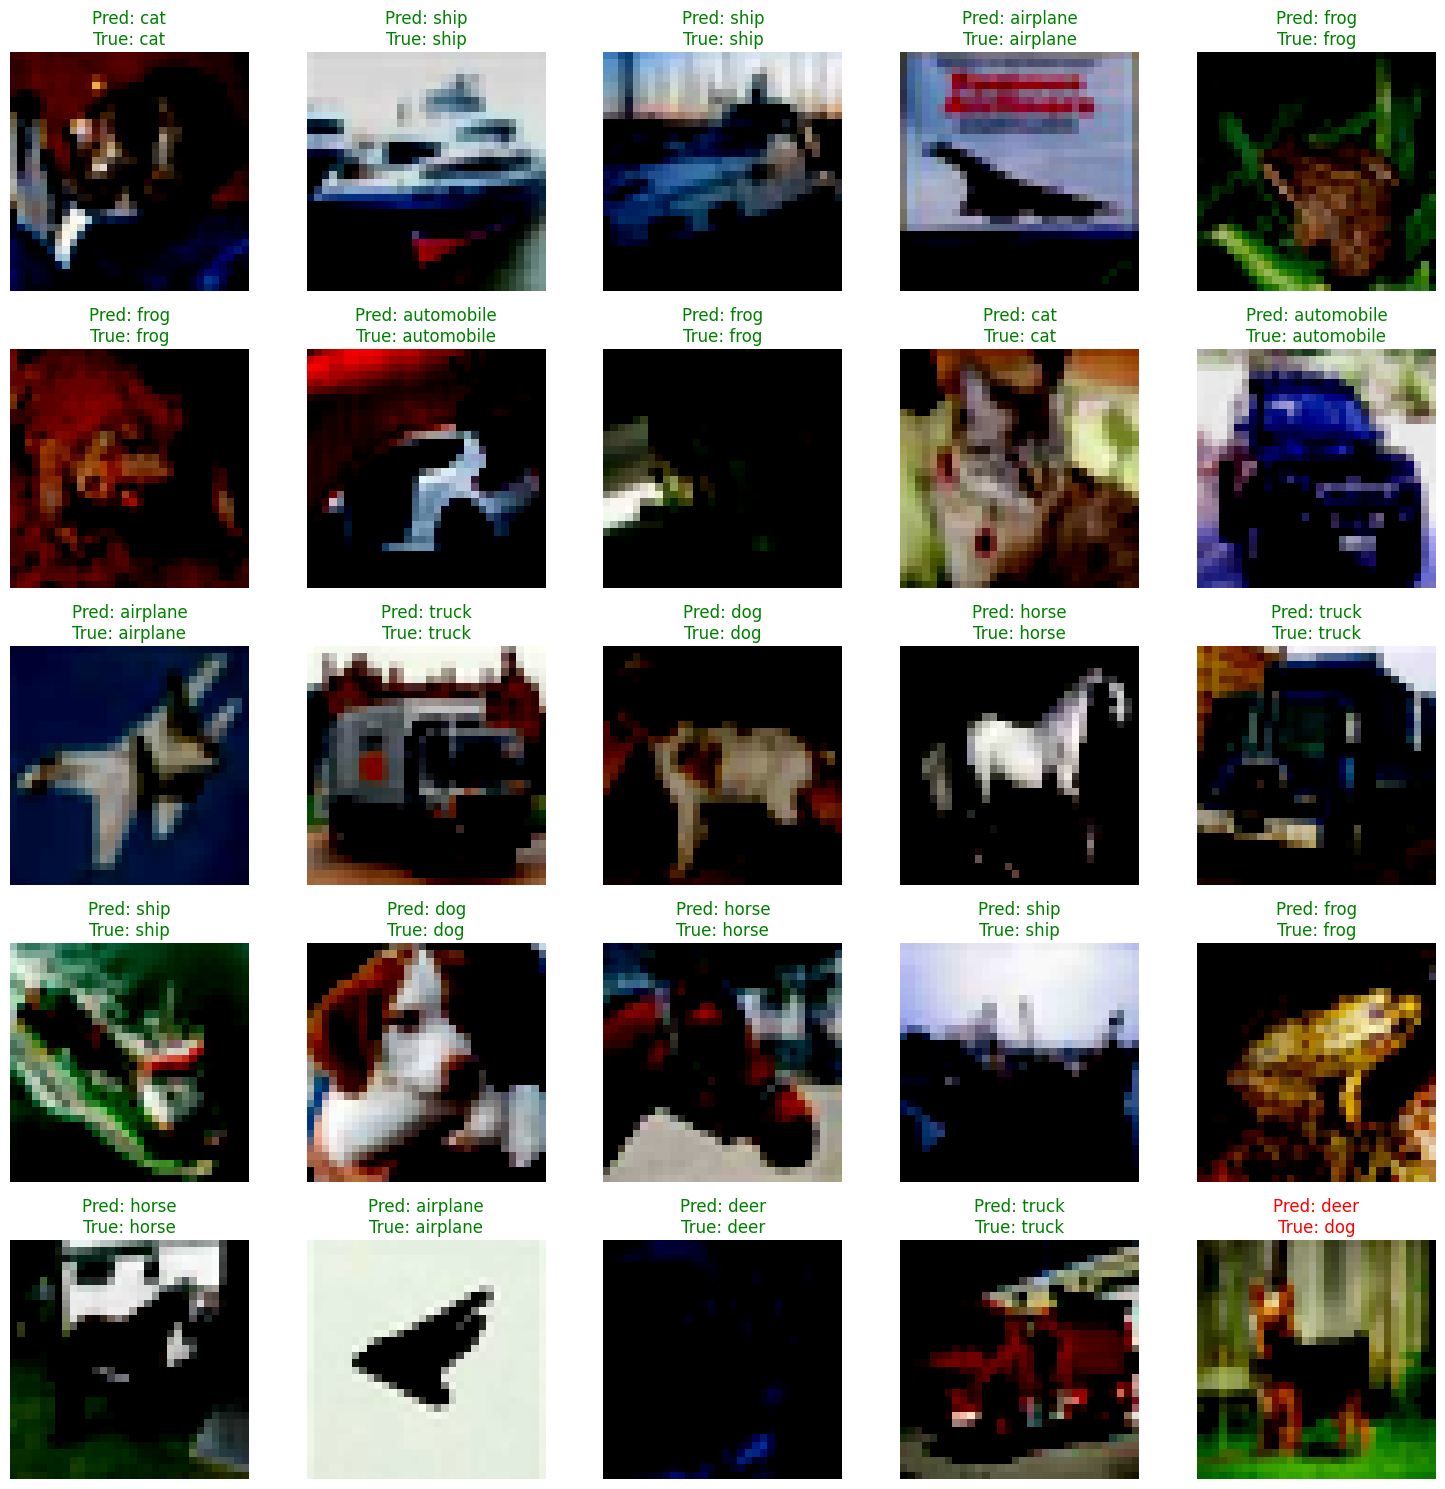

In [37]:
# 예측 결과 시각화
Test_plot(model, test_DL, num_samples=25)

## 결론

이번에는 PyTorch를 사용하여 CIFAR10 데이터셋으로 다중 클래스 분류 모델을 구현하고 학습하는 과정을 학습했습니다.

특히, MLP와 CNN 모델을 구현하고, 두 모델의 성능을 비교하여 이해를 높이셨을 거라고 생각합니다.

주요 학습 내용은 다음과 같습니다.

1. CIFAR10 데이터셋 로딩, 전처리 및 탐색
2. 다양한 모델 구현 (MLP, CNN)
3. 손실 함수 및 옵티마이저 이해 및 설정
4. 모델 학습 및 손실 시각화
5. 모델 저장 및 로드
6. 예측 결과 시각화
7. 모델 파라미터 수 계산
8. 모델 비교 및 성능 요약

추가로 시도해볼 수 있는 것들로는 다음과 같은 것들이 있습니다.

1. 데이터 증강 기법 적용
2. 다른 최적화 알고리즘 사용 (예: SGD with momentum)
3. 학습률 스케줄링 적용
4. 앙상블 기법 시도
5. 전이 학습 (Transfer Learning) 적용
6. 더 깊은 네트워크 구성 (CNN_deep 활용)
7. 혼동 행렬 및 추가 성능 지표 분석

이를 통해 모델의 성능을 더욱 개선하고, 컴퓨터 비전 분야의 딥러닝 모델에 대한 이해를 늘리실 수 있을거라고 생각합니다.

고생하셨습니다.